
## MNIST PyTorch - RNN

* Simple recurrent neural network for mnist
* To predict the class per 28x28 image, we now think of the image as a sequence of rows. 
* Therefore, you have 28 rows of 28 pixels each


In [1]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image


In [2]:

import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split



In [3]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable



## Parameters


In [4]:

learning_rate    = 0.003  ## Adam default   ## 0.001
batch_size       = 1000   ## 32
N_Epochs         = 20  ##27000  

seq_len          = 28     # MNIST data input (img shape: 28*28)
size_of_vector   = 28     # chunks per image
rnn_hidden_size  = 128    # size of rnn
n_classes        = 10     # MNIST total classes (0-9 digits) ## B



## Read the data


In [5]:

data_path = "data/MNISTdata/"


mnist_train = datasets.MNIST(data_path, train=True, download=True)


In [6]:

mnist_test = datasets.MNIST(data_path, train=False, download=True)


In [7]:

mnist_train_tr = datasets.MNIST(data_path, train=True, download=False, 
                                            transform=transforms.Compose([
                                                transforms.ToTensor()
                                            ]))
mnist_test_tr  = datasets.MNIST(data_path, train=False, download=False, 
                                            transform=transforms.Compose([
                                                transforms.ToTensor()
                                            ]))



## View the Images


In [8]:

Image.fromarray(  mnist_test_tr.data[423].numpy()  ) 


In [9]:

## mnist_train_tr.data = mnist_train_tr.data.view(60000, 1, 28, 28)

mnist_train_tr.data.shape


torch.Size([60000, 28, 28])


## Create Data Loaders


In [10]:

mnist_train_tr.data.shape


torch.Size([60000, 28, 28])

In [11]:

mnist_test_tr.data.shape


torch.Size([10000, 28, 28])

In [12]:


train_dl  = torch.utils.data.DataLoader(mnist_train_tr, batch_size=batch_size, shuffle=True  ) 
test_dl   = torch.utils.data.DataLoader(mnist_test_tr,  batch_size=batch_size, shuffle=False ) 



## Utility Functions


In [13]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat 


In [14]:

def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()



## Convert Batches to sequence

* batch_x has tensors of 28x28 which need to be converted to a sequence
* Reshape data to get 28 in seq_len, N_batches, 28 features in vector



In [15]:
## MNIST data input (img shape: 28*28)
## seq_len         = 28     
## size_of_vector  = 28     
## batch_size     

## Permute converts to [seq_len=28, batch_size, size_of_vector=28]

def make_img_to_sequence(batch_x):
      
    batch_x_new = batch_x.permute(1, 0, 2)
    
    return batch_x_new



## Basic RNN


In [16]:

## rnn_hidden_size  = 128    # size of rnn hidden layer
## n_classes        = 10     # MNIST total classes (0-9 digits) 


class MNIST_RNN_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.n_layers       = 1            ## number of hidden layers
        self.hidden_dim     = 128
        self.seq_len        = 28
        self.size_of_vector = 28
        
        ##                   (size_of_vector, rnn_hidden_size, n_layers)  
        self.rnn1            = nn.RNN(    28,             128,        1)   
        
        self.dropout         = nn.Dropout(0.2)
        self.fully_connected = nn.Linear(128, 10)

    
    def init_hidden(self,):
        ## Initial hidden layer in time is all zeros
        ##                (n_layers,  batch_size, rnn_hidden_size)
        return torch.zeros(       1,  batch_size,             128)

    

    def forward(self, xb):
        
        batch_x_seq        = make_img_to_sequence( xb )
        
        self.hidden        = self.init_hidden()      ## the initial hidden state

        ## self.hidden now contains the final hidden state 
        ## for each image in the batch
        rnn_o, self.hidden = self.rnn1(batch_x_seq, self.hidden)        
        rnn_o              = self.dropout(rnn_o)
        
        
        out                = self.fully_connected(self.hidden)
        
        ##                     batch_size, n_classes) 
        y_pred             = out.view( -1,        10) 
        
        return y_pred
    
     



## Main Loop


In [17]:

def training_loop( N_Epochs, model, loss_fn, opt  ):
    
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            
            xb = torch.squeeze(xb, dim=1)
                        
            y_pred = model( xb )

            loss   = loss_fn(y_pred, yb)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        if epoch % 1 == 0:
            print(epoch, "loss=", loss)



## Core Functions


In [18]:

model     = MNIST_RNN_Net()

loss_fn   = nn.CrossEntropyLoss( )  

opt       = torch.optim.Adam( model.parameters(), lr=learning_rate )

training_loop(  N_Epochs, model, loss_fn, opt  )
    


0 loss= tensor(0.7966, grad_fn=<NllLossBackward0>)
1 loss= tensor(0.5190, grad_fn=<NllLossBackward0>)
2 loss= tensor(0.3908, grad_fn=<NllLossBackward0>)
3 loss= tensor(0.3493, grad_fn=<NllLossBackward0>)
4 loss= tensor(0.2222, grad_fn=<NllLossBackward0>)
5 loss= tensor(0.2323, grad_fn=<NllLossBackward0>)
6 loss= tensor(0.1736, grad_fn=<NllLossBackward0>)
7 loss= tensor(0.1896, grad_fn=<NllLossBackward0>)
8 loss= tensor(0.1853, grad_fn=<NllLossBackward0>)
9 loss= tensor(0.1508, grad_fn=<NllLossBackward0>)
10 loss= tensor(0.2498, grad_fn=<NllLossBackward0>)
11 loss= tensor(0.1576, grad_fn=<NllLossBackward0>)
12 loss= tensor(0.1109, grad_fn=<NllLossBackward0>)
13 loss= tensor(0.1599, grad_fn=<NllLossBackward0>)
14 loss= tensor(0.1040, grad_fn=<NllLossBackward0>)
15 loss= tensor(0.1183, grad_fn=<NllLossBackward0>)
16 loss= tensor(0.1157, grad_fn=<NllLossBackward0>)
17 loss= tensor(0.0969, grad_fn=<NllLossBackward0>)
18 loss= tensor(0.0790, grad_fn=<NllLossBackward0>)
19 loss= tensor(0.1113


## Test set


In [19]:

f1_scores_to_plot = []

with torch.no_grad():
    for xb, yb in test_dl:
        
        xb = torch.squeeze(xb, dim=1)
        
        y_pred = model(  xb  )
        
        vals, indeces = torch.max( y_pred, dim=1  )
        preds = indeces
        f1, last_conf_mtrx = print_metrics_function(yb, preds)
        f1_scores_to_plot.append(f1)



Accuracy: 0.95
Confusion Matrix:
[[ 84   0   0   0   0   0   1   0   0   0]
 [  0 123   0   1   0   0   0   0   2   0]
 [  1   0 104   2   0   0   0   2   6   1]
 [  0   0   0 101   0   5   0   0   0   1]
 [  0   0   0   0 105   0   1   0   0   4]
 [  0   0   0   1   1  83   1   0   1   0]
 [  2   0   0   0   2   0  83   0   0   0]
 [  0   0   0   1   1   0   0  97   0   0]
 [  0   1   1   0   2   0   1   0  84   0]
 [  0   0   0   0   1   2   0   0   2  89]]
Precision: 0.954
Recall: 0.953
F1-mesure: 0.953
Accuracy: 0.95
Confusion Matrix:
[[ 89   0   0   0   0   0   1   0   0   0]
 [  0 106   0   1   0   0   0   0   1   0]
 [  1   0  99   0   0   1   0   1   1   0]
 [  0   0   0  95   0   1   0   2   0   2]
 [  0   0   0   0 100   0   3   0   0   4]
 [  0   0   0   0   1  87   1   1   1   1]
 [  1   0   0   0   2   3  84   0   1   0]
 [  0   1   2   0   0   0   0 100   1   2]
 [  0   0   0   0   0   1   1   1 100   0]
 [  0   0   0   1   2   4   0   0   1  92]]
Precision: 0.952
Recall:

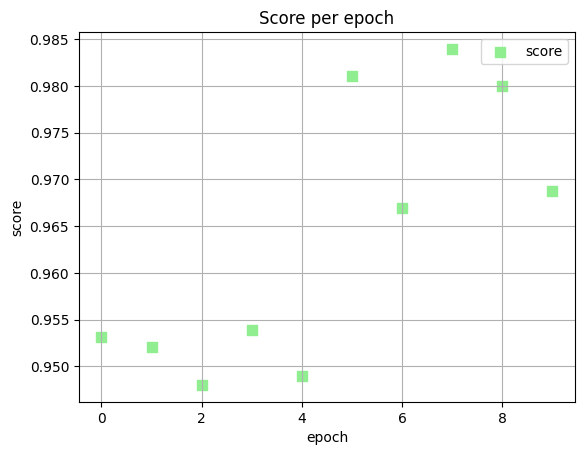

In [20]:

plot_metric_per_epoch(f1_scores_to_plot)


In [21]:

print(last_conf_mtrx )


[[100   0   0   0   0   2   0   0   0   0]
 [  0 118   0   0   1   0   0   0   0   0]
 [  2   0  85   2   0   2   0   2   5   1]
 [  0   0   0 101   0   0   0   0   0   1]
 [  0   0   0   0  91   0   0   1   0   0]
 [  3   0   0   0   0  81   1   0   0   0]
 [  0   0   0   0   0   2 100   0   0   0]
 [  0   0   3   0   0   0   0 112   0   0]
 [  0   0   0   0   0   1   0   0  93   0]
 [  0   0   0   0   1   0   0   1   0  88]]


In [22]:

sum(f1_scores_to_plot) / len(f1_scores_to_plot)


0.9636744832580204


## RNN Basic Simple Example


In [23]:

##                (vector_size, hidden_size,  n_layers)
rnn_basic_rc = nn.RNN(      10,          20,         2)


In [24]:

## This is the data
##                              28,        1000,             28)
##                     (   seq_len,  batch_size,    vector_size)
input_basic_rnn = torch.randn(   5,           3,             10)
input_basic_rnn.shape


torch.Size([5, 3, 10])

In [25]:

##            (n_layers,  batch_size,  hidden_size)
h0 = torch.randn(     2,           3,           20)
h0.shape


torch.Size([2, 3, 20])

In [26]:

output_zz, hn = rnn_basic_rc(input_basic_rnn, h0)


In [27]:

hn.shape


torch.Size([2, 3, 20])

In [28]:

output_zz.shape


torch.Size([5, 3, 20])


## Figuring out RNN model maths


In [29]:

N_batches_rc = 100


In [30]:
## xb  shape (batch_size,    seq_len,     vector_size)

xb_rc = torch.randn(N_batches_rc, 28,  28)

xb_rc.shape


torch.Size([100, 28, 28])

In [31]:

xb_rc = xb_rc.permute(1, 0, 2)

xb_rc.shape


torch.Size([28, 100, 28])

In [32]:

## hidden has shape (n_layers  , batch_size, rnn_hidden_size)
## r_out, (h_n, h_c) = self.rnn(x, hidden = None)  
## None represents zero initial hidden state

##                       (  n_layers,     batch_size, rnn_hidden_size)
hidden_rc   = torch.zeros(         1,   N_batches_rc,             128)
hidden_rc.shape


torch.Size([1, 100, 128])

In [33]:

hidden_rc


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [34]:

rnn_rc    = nn.RNN(        28,     128,    1) 


In [35]:

rnn_o, hidden_rc = rnn_rc(xb_rc, hidden_rc  )        
     
print(rnn_o.shape)


torch.Size([28, 100, 128])


In [36]:

print(hidden_rc.shape)


torch.Size([1, 100, 128])


In [37]:

hidden_rc


tensor([[[-0.4040,  0.2119, -0.0517,  ..., -0.2074, -0.1819,  0.4931],
         [ 0.4326,  0.2581, -0.1940,  ...,  0.0086, -0.4062, -0.2339],
         [ 0.1769,  0.2437,  0.2470,  ...,  0.3818, -0.2528, -0.1768],
         ...,
         [-0.0963, -0.4352,  0.0331,  ...,  0.2192, -0.3994, -0.1072],
         [-0.5090, -0.4528, -0.1578,  ...,  0.1001, -0.3791,  0.3332],
         [ 0.1098,  0.1519,  0.4995,  ..., -0.0235,  0.2665, -0.1909]]],
       grad_fn=<StackBackward0>)

In [38]:

drop_rc = nn.Dropout(0.2)


In [39]:

rnn_o  = drop_rc(  rnn_o  )

rnn_o.shape


torch.Size([28, 100, 128])

In [40]:

fully_connected_rc = nn.Linear(128, 10)


In [41]:

out  = fully_connected_rc( hidden_rc )
out.shape


torch.Size([1, 100, 10])

In [42]:

y_pred = out.view(-1, 10)    # batch_size X n_output for 10 classes
        


In [43]:

y_pred.shape


torch.Size([100, 10])

In [45]:

## rnn_o shape (seq_len,    batch_size,       hidden)

rnn_o.shape


torch.Size([28, 100, 128])

In [46]:

rnn_out_temp = rnn_o[-1, :, :]    ## -1 means the last 
rnn_out_temp.shape


torch.Size([100, 128])

In [47]:

## choose rnn_out at the last time step

out_last_time_step  = fully_connected_rc( rnn_out_temp )
out_last_time_step.shape




torch.Size([100, 10])